# Measuring Context Usage with CXMI

This notebook contains the code to measure CXMI for contextual models trained in this libray

Start by setting the path for your checkpoint of interest. This should ideally be a model trained with *dynamic* context size. 
We also need set context size for which we are measuring CXMI. We also need to set the languages in order to load the sentencepiece models.

In [1]:
%load_ext autoreload
%autoreload 2
model_ckpt="/projects/tir4/users/pfernand/ted-cxmi-experiments-disjoint/TrainModel/TgtLang.fr/checkpoint_dir/"
#model_ckpt="/projects/tir5/users/patrick/checkpoints/iwslt2017/en-fr/one_to_five_sampled_pretrained_drop03_1/"
source_context_size=0
target_context_size=1
source_lang="en"
target_lang="fr"

And then load the models and associated files such as the vocabularies into memory

In [2]:
import os
import sentencepiece as sp
import contextual_mt
from fairseq import utils, hub_utils

package = hub_utils.from_pretrained(
    model_ckpt, checkpoint_file="checkpoint_best.pt"
)
models = package["models"]
for model in models:
    model.cuda()
    model.eval()

# load dict, params and generator from task
src_dict = package["task"].src_dict
tgt_dict = package["task"].tgt_dict

# load sentencepiece models (assumes they are in the checkpoint dirs)
# FIXME: is there someway to have it in `package`
if os.path.exists(os.path.join(model_ckpt, "spm.model")):
    spm = sp.SentencePieceProcessor()
    spm.Load(os.path.join(model_ckpt, "spm.model"))
    src_spm = spm
    tgt_spm = spm
else:
    src_spm = sp.SentencePieceProcessor()
    src_spm.Load(os.path.join(model_ckpt, f"spm.{source_lang}.model"))
    tgt_spm = sp.SentencePieceProcessor()
    tgt_spm.Load(os.path.join(model_ckpt, f"spm.{target_lang}.model"))

ImportError: /home/kayoy/miniconda3/envs/venv/lib/python3.8/site-packages/numpy/random/mtrand.cpython-38-x86_64-linux-gnu.so: file too short

## Measuring CXMI

To measure CXMI, we need an held-out dataset. Currently, two types of dataset are supported

* A standard dataset
* A contrastive dataset

### Standard Dataset 

To measure the CXMI for standart dataset, define the source, target and docids files

In [56]:
source_file="/projects/tir1/corpora/dialogue_mt/ted-talks-aligned/test.en"
target_file="/projects/tir1/corpora/dialogue_mt/ted-talks-aligned/test." + target_lang
docids_file="/projects/tir1/corpora/dialogue_mt/ted-talks-aligned/test.docids"
batch_size=8

In [3]:
source_file="/projects/tir1/corpora/dialogue_mt/iwslt2017/en-fr/test.en-fr.en"
target_file="/projects/tir1/corpora/dialogue_mt/iwslt2017/en-fr/test.en-fr.fr"
docids_file="/projects/tir1/corpora/dialogue_mt/iwslt2017/en-fr/test.en-fr.docids"
batch_size=8

And run the following cell to compute the corpus-level cxmi

In [4]:
from contextual_mt.utils import parse_documents
from contextual_mt.docmt_cxmi import compute_cxmi
import numpy as np

# load files needed
with open(source_file, "r") as src_f:
    srcs = [line.strip() for line in src_f]
with open(docids_file, "r") as docids_f:
    docids = [int(idx) for idx in docids_f]
with open(target_file, "r") as tgt_f:
    refs = [line.strip() for line in tgt_f]

documents = parse_documents(srcs, refs, docids)
sample_cxmis, ids = compute_cxmi(
        documents,
        models,
        src_spm,
        src_dict,
        tgt_spm,
        tgt_dict,
        source_context_size,
        target_context_size,
        batch_size=batch_size
)
print(np.mean(sample_cxmis))

-0.017390486


### Contrastive dataset

To compute CXMI for either ContraPro or Bawden's contrastive dataset, start by defining the dataset files

In [24]:
import torch
from contextual_mt.docmt_contrastive_eval import load_contrastive
from contextual_mt.contextual_dataset import collate
from contextual_mt.utils import encode, decode, create_context
from fairseq.sequence_scorer import SequenceScorer

bawden=True
source_file="/home/pfernand/repos/discourse-mt-test-sets/test-sets/lexical_choice.current.en"
target_file="/home/pfernand/repos/discourse-mt-test-sets/test-sets/lexical_choice.current.fr"
src_context_file="/home/pfernand/repos/discourse-mt-test-sets/test-sets/lexical_choice.prev.en"
tgt_context_file="/home/pfernand/repos/discourse-mt-test-sets/test-sets/lexical_choice.prev.fr"
#source_file="/home/pfernand/repos/ContraPro/contrapro.text.en"
#target_file="/home/pfernand/repos/ContraPro/contrapro.text.de"
#src_context_file="/home/pfernand/repos/ContraPro/contrapro.context.en"
#tgt_context_file="/home/pfernand/repos/ContraPro/contrapro.context.de"


# load files
srcs, all_tgts, tgt_labels, srcs_contexts, tgts_contexts = load_contrastive(
    source_file, target_file, src_context_file, tgt_context_file, dataset="bawden" if bawden else "contrapro"
)

scorer = SequenceScorer(tgt_dict)
sample_cxmis = []
corrects = []
b_corrects = []
for src, src_ctx, contr_tgts, tgt_ctx in zip(srcs, srcs_contexts, all_tgts, tgts_contexts):
    src = encode(src, src_spm, src_dict)
    src_ctx = [encode(ctx, src_spm, src_dict) for ctx in src_ctx]
    contr_tgts = [encode(tgt, tgt_spm, tgt_dict) for tgt in contr_tgts]
    tgt_ctx = [encode(ctx, tgt_spm, tgt_dict) for ctx in tgt_ctx]
    baseline_samples = []
    contextual_samples = []

    for tgt in contr_tgts:
        baseline_src_context = create_context(
            src_ctx,
            0,
            break_id=src_dict.index("<brk>"),
            eos_id=src_dict.eos(),
        )
        baseline_tgt_context = create_context(
            tgt_ctx,
            0,
            break_id=tgt_dict.index("<brk>"),
            eos_id=tgt_dict.eos(),
        )
        contextual_src_context = create_context(
            src_ctx,
            source_context_size,
            break_id=src_dict.index("<brk>"),
            eos_id=src_dict.eos(),
        )
        contextual_tgt_context = create_context(
            tgt_ctx,
            target_context_size,
            break_id=tgt_dict.index("<brk>"),
            eos_id=tgt_dict.eos())

        full_src = torch.cat([src, torch.tensor([src_dict.eos()])])
        full_tgt = torch.cat([tgt, torch.tensor([tgt_dict.eos()])])
        baseline_sample = {
            "id": 0,
            "source": full_src,
            "src_context": baseline_src_context,
            "target": full_tgt,
            "tgt_context": baseline_tgt_context,
        }
        contextual_sample = {
            "id": 0,
            "source": full_src,
            "src_context": contextual_src_context,
            "target": full_tgt,
            "tgt_context": contextual_tgt_context,
        }
        baseline_samples.append(baseline_sample)
        contextual_samples.append(contextual_sample)

    baseline_sample = collate(
        baseline_samples,
        pad_id=src_dict.pad(),
        eos_id=src_dict.eos(),
    )
    contextual_sample = collate(
        contextual_samples,
        pad_id=src_dict.pad(),
        eos_id=src_dict.eos()
    )

    baseline_sample = utils.move_to_cuda(baseline_sample)
    contextual_sample = utils.move_to_cuda(contextual_sample)

    baseline_out = scorer.generate(models, baseline_sample)
    contextual_out = scorer.generate(models, contextual_sample)

    scores = [h[0]["score"] for h in contextual_out]

    most_likely = torch.argmax(torch.stack(scores))
    correct = most_likely == 0
    baseline_correct = torch.argmax(torch.stack([h[0]["score"] for h in baseline_out])) == 0

    b_corrects.append(baseline_correct)
    corrects.append(correct)
    sample_cxmis.append(contextual_out[0][0]["score"].cpu() - baseline_out[0][0]["score"].cpu())

corrects = np.stack([correct.cpu().numpy() for correct in corrects])
b_corrects = np.stack([b_correct.cpu().numpy() for b_correct in b_corrects])
print(np.mean(sample_cxmis))

0.022161597


#### Measuring Correlations

To measure the correlation of the *per-sample* CXMI with the performance on samples that requires context, run

In [27]:
from scipy import stats

binary_vars = np.stack([not b_c and c for b_c, c in zip(b_corrects, corrects)])
print(scipy.stats.pointbiserialr(binary_vars, sample_cxmis))

PointbiserialrResult(correlation=0.025460697287605066, pvalue=0.7204408014491894)


### Analysing Samples

**TODO**

In [58]:
from IPython.display import Markdown, display

def print_coloured(subwords, weights, max_alpha=0.8):
    text = []
    colour = ["250, 133, 205" if w >= 0 else "135,206,250" for w in weights]
    weights = np.abs(weights)
    weights = weights / np.max(weights)
    for i, subword in enumerate(subwords):
        if subword[0] == "▁":
            subword = subword[1:]
            if i:
                text.append(" ")
        colorstr = f"<span style='background-color:rgba({colour[i]},{weights[i] / max_alpha:.03f}'>{subword}</span>"
        text.append(colorstr)
    display(Markdown(" ".join(text)))

In [50]:
ja_word_cxmis = word_cxmis

In [59]:
ko_word_cxmis, ids2 = compute_cxmi(
        documents,
        models,
        src_spm,
        src_dict,
        tgt_spm,
        tgt_dict,
        source_context_size,
        target_context_size,
        batch_size=batch_size,
        token_level=True
)
assert ids2 == ids

In [60]:
from contextual_mt.utils import encode

for i, (_, w_cxmis, idx) in enumerate(sorted(zip(sample_cxmis, ko_word_cxmis, ids), key=lambda p: p[0], reverse=False)):
    subwords = tgt_spm.encode(documents[idx[0]][idx[1]][1], out_type='str')
    print(i)
    print(f"src_context: {documents[idx[0]][idx[1]-1][0]}")
    print(f"tgt_context: {documents[idx[0]][idx[1]-1][1]}")
    print(f"src: {documents[idx[0]][idx[1]][0]}")
    print_coloured(subwords, w_cxmis)
    if i > 50:
        break

0
src_context: "Sure , she had aged a little ."
tgt_context: "그래 , 물론 그녀도 좀 나이를 먹었다 ."
src: "In fact , she had aged a lot ."


<span style='background-color:rgba(250, 133, 205,0.001'>"</span> <span style='background-color:rgba(135,206,250,0.419'>뭐</span>   <span style='background-color:rgba(250, 133, 205,0.017'>사실</span>   <span style='background-color:rgba(135,206,250,0.004'>,</span>   <span style='background-color:rgba(250, 133, 205,0.371'>많이</span>   <span style='background-color:rgba(135,206,250,0.439'>먹</span> <span style='background-color:rgba(135,206,250,1.250'>었다</span>   <span style='background-color:rgba(135,206,250,0.459'>."</span>

1
src_context: "But he looked at me , and he said , &quot; &quot; Son &quot; &quot; — he &apos;s my age , by the way , he calls me son , I love that — he says , &quot; &quot; Son , I &apos;m a captain of a crab boat ."
tgt_context: "그는 저를 바라보며 “ 젊은이 … 그는 제 또래였는데 , 근데 , 저를 젊은이라고 부르더군요 , 뭐 괜찮았어요 … 그는 “ 젊은이 , 나는 이 게잡이 배의 선장이다 ."
src: "My responsibility is not to get you home alive ."


<span style='background-color:rgba(250, 133, 205,0.000'>"</span> <span style='background-color:rgba(135,206,250,0.862'>내</span>   <span style='background-color:rgba(250, 133, 205,0.091'>일은</span>   <span style='background-color:rgba(135,206,250,0.322'>널</span>   <span style='background-color:rgba(135,206,250,0.030'>안전하게</span>   <span style='background-color:rgba(135,206,250,0.672'>집에</span>   <span style='background-color:rgba(135,206,250,0.006'>보내는</span>   <span style='background-color:rgba(135,206,250,0.122'>게</span>   <span style='background-color:rgba(135,206,250,1.250'>아니다</span>   <span style='background-color:rgba(135,206,250,0.001'>."</span>

2
src_context: "No , if you want to know what society &apos;s going to be like in 20 years , ask a kindergarten teacher ."
tgt_context: "20년 후 사회가 어떤 모습일지 정말로 알고 싶으시다면 , 유치원 교사분들께 여쭤보세요 ."
src: "They know ."


<span style='background-color:rgba(250, 133, 205,0.002'>"</span> <span style='background-color:rgba(135,206,250,0.346'>그</span>   <span style='background-color:rgba(135,206,250,1.250'>분들은</span>   <span style='background-color:rgba(250, 133, 205,0.298'>알아요</span>   <span style='background-color:rgba(250, 133, 205,0.024'>."</span>

3
src_context: "Boy : It &apos;s lighting up ."
tgt_context: "소년 : 불이 들어오잖아 ."
src: "So when you put four ."


<span style='background-color:rgba(135,206,250,0.031'>"</span> <span style='background-color:rgba(135,206,250,0.232'>그럼</span>   <span style='background-color:rgba(250, 133, 205,0.042'>4</span> <span style='background-color:rgba(135,206,250,0.012'>개를</span>   <span style='background-color:rgba(135,206,250,0.063'>올려</span>   <span style='background-color:rgba(135,206,250,0.070'>놓으면</span>   <span style='background-color:rgba(135,206,250,0.345'>되</span> <span style='background-color:rgba(135,206,250,1.250'>네</span>   <span style='background-color:rgba(135,206,250,0.015'>."</span>

4
src_context: "The earth moved for both of them ."
tgt_context: "그둘 모두 오르가즘에 도달했다 ."
src: "And they lived together happily ever after ."


<span style='background-color:rgba(250, 133, 205,0.002'>"</span> <span style='background-color:rgba(250, 133, 205,0.004'>그리고</span>   <span style='background-color:rgba(250, 133, 205,0.029'>두</span>   <span style='background-color:rgba(250, 133, 205,0.274'>커플</span> <span style='background-color:rgba(250, 133, 205,0.016'>은</span>   <span style='background-color:rgba(250, 133, 205,0.003'>오래</span> <span style='background-color:rgba(250, 133, 205,0.088'>도록</span>   <span style='background-color:rgba(135,206,250,0.135'>행복하게</span>   <span style='background-color:rgba(135,206,250,0.297'>살았</span> <span style='background-color:rgba(135,206,250,1.250'>다</span>   <span style='background-color:rgba(135,206,250,0.030'>."</span>

5
src_context: "So obviously when we think about nonverbal behavior , or body language — but we call it nonverbals as social scientists — it &apos;s language , so we think about communication ."
tgt_context: "비언어적 행동이나 바디랭귀지를 보통 사회과학자들은 비언어라고 부르는데요 . 그것도 일종의 언어에요 . 그래서 소통이란것은"
src: "When we think about communication , we think about interactions ."


<span style='background-color:rgba(250, 133, 205,0.005'>"</span> <span style='background-color:rgba(135,206,250,0.896'>상</span> <span style='background-color:rgba(250, 133, 205,0.234'>호</span> <span style='background-color:rgba(135,206,250,0.324'>적인</span>   <span style='background-color:rgba(250, 133, 205,0.237'>작용</span> <span style='background-color:rgba(135,206,250,0.071'>이라고</span>   <span style='background-color:rgba(135,206,250,0.870'>할수</span>   <span style='background-color:rgba(135,206,250,1.215'>있죠</span>   <span style='background-color:rgba(135,206,250,1.250'>."</span>

6
src_context: "It &apos;s the interchange of ideas , the meeting and mating of ideas between them , that is causing technological progress , incrementally , bit by bit ."
tgt_context: "아이디어를 서로 교환하고 , 아이디어간의 만남과 조합이 기술적인 진보를 점진적으로 이루어내는 것입니다"
src: "However , bad things happen ."


<span style='background-color:rgba(250, 133, 205,0.001'>"</span> <span style='background-color:rgba(135,206,250,0.025'>하지만</span>   <span style='background-color:rgba(250, 133, 205,0.029'>나쁜</span>   <span style='background-color:rgba(135,206,250,0.164'>일</span> <span style='background-color:rgba(250, 133, 205,0.092'>들도</span>   <span style='background-color:rgba(135,206,250,0.062'>일어납니다</span> <span style='background-color:rgba(135,206,250,1.250'>"</span>

7
src_context: "However , some of the facility authority doesn &apos;t want us to do it , because , they said , simply , it &apos;s become more difficult to control them ."
tgt_context: "하지만 여러 기관에서 우리가 하는 하는일을 원치 않았어요 , 왜냐하면 사람들을 관리하기가 더 어려워졌기 때문이었습니다 ."
src: "But it &apos;s really necessary to do it ."


<span style='background-color:rgba(250, 133, 205,0.002'>"</span> <span style='background-color:rgba(135,206,250,0.002'>하지만</span>   <span style='background-color:rgba(250, 133, 205,0.366'>이것은</span>   <span style='background-color:rgba(135,206,250,0.149'>꼭</span>   <span style='background-color:rgba(250, 133, 205,0.016'>필요한</span>   <span style='background-color:rgba(135,206,250,0.288'>일이</span> <span style='background-color:rgba(135,206,250,1.250'>었어요</span>   <span style='background-color:rgba(135,206,250,0.028'>."</span>

8
src_context: "Let me know when you &apos;ve got them . Let &apos;s shoot ."
tgt_context: "그놈들 잡으면 알려줘 . 발사 ."
src: "Light &apos; em all up ."


<span style='background-color:rgba(135,206,250,0.001'>"</span> <span style='background-color:rgba(135,206,250,0.416'>다</span>   <span style='background-color:rgba(250, 133, 205,0.098'>날려</span> <span style='background-color:rgba(135,206,250,0.166'>버려</span>   <span style='background-color:rgba(135,206,250,1.250'>."</span>

9
src_context: "There &apos;s a clock , clock , clock , clock ."
tgt_context: "거기에 시계 , 시계 , 시계 , 시계가 있었어요 ."
src: "The time &apos;s going backwards because I &apos;m inside of it ."


<span style='background-color:rgba(250, 133, 205,0.001'>"</span> <span style='background-color:rgba(250, 133, 205,0.109'>시간</span> <span style='background-color:rgba(250, 133, 205,0.050'>은</span>   <span style='background-color:rgba(250, 133, 205,0.094'>거꾸로</span>   <span style='background-color:rgba(250, 133, 205,0.068'>가</span> <span style='background-color:rgba(135,206,250,0.422'>요</span>   <span style='background-color:rgba(135,206,250,0.078'>,</span>   <span style='background-color:rgba(250, 133, 205,0.031'>왜냐하면</span>   <span style='background-color:rgba(250, 133, 205,0.160'>저는</span>   <span style='background-color:rgba(135,206,250,1.250'>시계</span>   <span style='background-color:rgba(250, 133, 205,0.037'>안에</span>   <span style='background-color:rgba(135,206,250,0.079'>있으니까요</span>   <span style='background-color:rgba(135,206,250,0.004'>."</span>

10
src_context: "I will not dance to that beating ."
tgt_context: "나는 그 울림에 맞춰 춤추지 않겠습니다 ."
src: "I know that beat ."


<span style='background-color:rgba(250, 133, 205,0.001'>"</span> <span style='background-color:rgba(135,206,250,1.250'>나는</span>   <span style='background-color:rgba(135,206,250,0.123'>그</span>   <span style='background-color:rgba(135,206,250,0.035'>리듬</span> <span style='background-color:rgba(250, 133, 205,0.011'>을</span>   <span style='background-color:rgba(135,206,250,0.010'>압니다</span>   <span style='background-color:rgba(135,206,250,0.022'>."</span>

11
src_context: "And by the way , that &apos;s one of the reasons that I &apos;m not interested in the debate about I.Q. , about whether some groups have higher I.Q.s than other groups ."
tgt_context: "덧붙여 말씀드리면 , 그것이 바로 제가 아이큐와 관련된 논쟁에 흥미를 가지지 않는 이유중 하나입니다 어떤 집단들이 다른 집단들보다 더 높은 아이큐를 가져느냐 아느냐 하는 논쟁들 말이죠"
src: "It &apos;s completely irrelevant ."


<span style='background-color:rgba(250, 133, 205,0.002'>"</span> <span style='background-color:rgba(135,206,250,0.116'>정말</span>   <span style='background-color:rgba(250, 133, 205,0.001'>부</span> <span style='background-color:rgba(135,206,250,0.103'>질</span> <span style='background-color:rgba(250, 133, 205,0.022'>없는</span>   <span style='background-color:rgba(135,206,250,0.737'>논쟁</span> <span style='background-color:rgba(250, 133, 205,0.112'>입니다</span> <span style='background-color:rgba(135,206,250,1.250'>"</span>

12
src_context: "Gusty entered her boldly and made love to her rhythmically while she filmed him , because she was a keen amateur pornographer ."
tgt_context: "거스티는 용감하게 그녀의 몸으로 돌진해 리드미컬하게 그녀와 사랑을 나눴다 . 그녀가 그를 촬영하는 동안 , 아 , 그녀는 아마추어 포르노작가였다 ."
src: "The earth moved for both of them ."


<span style='background-color:rgba(135,206,250,0.001'>"</span> <span style='background-color:rgba(135,206,250,0.339'>그</span> <span style='background-color:rgba(250, 133, 205,0.134'>둘</span>   <span style='background-color:rgba(135,206,250,0.061'>모두</span>   <span style='background-color:rgba(250, 133, 205,0.155'>오르</span> <span style='background-color:rgba(250, 133, 205,0.012'>가</span> <span style='background-color:rgba(135,206,250,0.011'>즘</span> <span style='background-color:rgba(135,206,250,0.017'>에</span>   <span style='background-color:rgba(250, 133, 205,0.145'>도달</span> <span style='background-color:rgba(135,206,250,1.250'>했다</span>   <span style='background-color:rgba(135,206,250,0.168'>."</span>

13
src_context: "The miracle of your mind isn &apos;t that you can see the world as it is ."
tgt_context: "우리 의식의 기적은 세상을 사실대로 보는것에 있지 아니하고 ,"
src: "It &apos;s that you can see the world as it isn &apos;t ."


<span style='background-color:rgba(250, 133, 205,0.001'>"</span> <span style='background-color:rgba(135,206,250,0.899'>사실</span> <span style='background-color:rgba(135,206,250,1.169'>이</span>   <span style='background-color:rgba(135,206,250,1.250'>아닌</span> <span style='background-color:rgba(135,206,250,0.425'>대로</span>   <span style='background-color:rgba(135,206,250,0.888'>볼</span>   <span style='background-color:rgba(250, 133, 205,0.012'>수</span>   <span style='background-color:rgba(135,206,250,0.293'>있다는</span>   <span style='background-color:rgba(135,206,250,0.255'>것입니다</span>   <span style='background-color:rgba(135,206,250,0.008'>."</span>

14
src_context: "And in the future , as we go forward , we will , of course , experience terrible things ."
tgt_context: "미래의 언젠가 우리는 물론 끔찍한 일들도 겪을 것입니다"
src: "There will be wars ; there will be depressions ; there will be natural disasters ."


<span style='background-color:rgba(250, 133, 205,0.000'>"</span> <span style='background-color:rgba(135,206,250,0.000'>전쟁</span> <span style='background-color:rgba(135,206,250,0.018'>도</span>   <span style='background-color:rgba(135,206,250,0.020'>있을</span>   <span style='background-color:rgba(250, 133, 205,0.080'>수</span>   <span style='background-color:rgba(250, 133, 205,0.012'>있고</span>   <span style='background-color:rgba(135,206,250,0.023'>경기</span> <span style='background-color:rgba(250, 133, 205,0.073'>침</span> <span style='background-color:rgba(135,206,250,0.035'>체</span> <span style='background-color:rgba(250, 133, 205,0.010'>도</span>   <span style='background-color:rgba(250, 133, 205,0.002'>있을</span>   <span style='background-color:rgba(135,206,250,0.035'>것입니다</span>   <span style='background-color:rgba(135,206,250,1.250'>자연</span>   <span style='background-color:rgba(250, 133, 205,0.006'>재</span> <span style='background-color:rgba(250, 133, 205,0.087'>해도</span>   <span style='background-color:rgba(250, 133, 205,0.003'>마찬가지죠</span> <span style='background-color:rgba(135,206,250,0.067'>"</span>

15
src_context: "What would be the price ?"
tgt_context: "비용은 얼마나 드는지"
src: "What should we do about it , and what will be the outcome ?"


<span style='background-color:rgba(250, 133, 205,0.001'>"</span> <span style='background-color:rgba(135,206,250,0.613'>무엇을</span>   <span style='background-color:rgba(250, 133, 205,0.032'>해야</span> <span style='background-color:rgba(135,206,250,0.898'>하며</span>   <span style='background-color:rgba(135,206,250,0.521'>거기서</span>   <span style='background-color:rgba(135,206,250,0.510'>얻는</span>   <span style='background-color:rgba(250, 133, 205,0.296'>것이</span>   <span style='background-color:rgba(135,206,250,0.078'>무엇인지</span> <span style='background-color:rgba(135,206,250,1.250'>"</span>

16
src_context: "Melanie picks up the lamb — two hands — one hand on both legs on the right , likewise on the left ."
tgt_context: "멜라니가 두 손으로 양을 들어 올립니다 . 한 손으로 오른쪽 두 발을 잡고 , 다른 손으로 왼쪽의 두 발을 잡았습니다 ."
src: "Lamb goes on the post , she opens it up ."


<span style='background-color:rgba(250, 133, 205,0.003'>"</span> <span style='background-color:rgba(135,206,250,1.250'>양을</span>   <span style='background-color:rgba(250, 133, 205,0.109'>기둥</span> <span style='background-color:rgba(250, 133, 205,0.082'>에</span>   <span style='background-color:rgba(135,206,250,0.456'>얹</span> <span style='background-color:rgba(135,206,250,0.171'>고</span>   <span style='background-color:rgba(135,206,250,0.192'>,</span>   <span style='background-color:rgba(135,206,250,0.614'>다리를</span>   <span style='background-color:rgba(135,206,250,0.079'>벌</span> <span style='background-color:rgba(135,206,250,0.554'>립니다</span>   <span style='background-color:rgba(135,206,250,0.006'>."</span>

17
src_context: "So I thought , even as architects , we can be involved in the reconstruction of temporary housing ."
tgt_context: "그래서 건축가로써 생각해봤습니다 . 우리는 임시 주거 공간의 재건축에 참여할수 있겠구나 ."
src: "We can make it better ."


<span style='background-color:rgba(250, 133, 205,0.001'>"</span> <span style='background-color:rgba(250, 133, 205,0.065'>우리가</span>   <span style='background-color:rgba(135,206,250,0.255'>좀</span>   <span style='background-color:rgba(135,206,250,0.001'>더</span>   <span style='background-color:rgba(250, 133, 205,0.005'>나은</span>   <span style='background-color:rgba(250, 133, 205,0.363'>환경을</span>   <span style='background-color:rgba(135,206,250,0.070'>만들수</span>   <span style='background-color:rgba(135,206,250,1.250'>있을거야</span>   <span style='background-color:rgba(135,206,250,0.007'>."</span>

18
src_context: "And I &apos;ll tell you now , that East Asianers , people from East Asia , are far more knowledgeable about the West than the West is about East Asia ."
tgt_context: "말하자면 동아시아인 , 동아시아의 사람들은 서양이 동아시아에 대해 아는 것보다 서양에 대해 훨씬 많이 알고 있습니다 ."
src: "Now this point is very germane , I &apos;m afraid , to the present ."


<span style='background-color:rgba(250, 133, 205,0.007'>"</span> <span style='background-color:rgba(135,206,250,0.036'>안타깝게도</span>   <span style='background-color:rgba(135,206,250,1.250'>현재는</span>   <span style='background-color:rgba(135,206,250,0.551'>더욱</span>   <span style='background-color:rgba(135,206,250,0.706'>그렇습니다</span>   <span style='background-color:rgba(135,206,250,0.056'>."</span>

19
src_context: "So I was like , okay , so we &apos;ve got the formula ready ."
tgt_context: "저는 마치 , 그래 좋아 , 이제 공식은 준비됐어 , 라고 하는 식이었어요 ."
src: "Now we need to get this thing into practice ."


<span style='background-color:rgba(250, 133, 205,0.003'>"</span> <span style='background-color:rgba(250, 133, 205,0.011'>이제</span>   <span style='background-color:rgba(135,206,250,0.168'>이걸</span>   <span style='background-color:rgba(250, 133, 205,0.117'>실용</span> <span style='background-color:rgba(135,206,250,0.086'>화하기</span> <span style='background-color:rgba(135,206,250,0.024'>만</span>   <span style='background-color:rgba(135,206,250,0.004'>하면</span>   <span style='background-color:rgba(135,206,250,0.237'>되는</span> <span style='background-color:rgba(135,206,250,0.338'>거</span> <span style='background-color:rgba(135,206,250,1.250'>였어요</span>   <span style='background-color:rgba(135,206,250,0.020'>."</span>

20
src_context: "So we &apos;ve created something called the collective brain ."
tgt_context: "우리는 그래서 집단 지성이라는 개념을 만들어 냈습니다"
src: "We &apos;re just the nodes in the network ."


<span style='background-color:rgba(250, 133, 205,0.002'>"</span> <span style='background-color:rgba(135,206,250,0.033'>우리는</span>   <span style='background-color:rgba(250, 133, 205,0.074'>네트워크의</span>   <span style='background-color:rgba(250, 133, 205,0.076'>매</span> <span style='background-color:rgba(135,206,250,0.055'>듭</span> <span style='background-color:rgba(135,206,250,0.196'>점</span> <span style='background-color:rgba(250, 133, 205,0.025'>일</span>   <span style='background-color:rgba(135,206,250,0.044'>뿐이죠</span> <span style='background-color:rgba(135,206,250,1.250'>"</span>

21
src_context: "And I &apos;m thinking , &quot; &quot; Oh yeah , the square root of the length is proportional to its period . &quot; &quot; ( Laughter ) I keep climbing up , go back ."
tgt_context: "그리고 저는 생각해요 , 그래 맞아 , 길이의 제곱근은 그것의 구간에 비례해 . ( 웃음 ) 저는 다시 계속 올라가요 ."
src: "I go to a place where a dowel splits off ."


<span style='background-color:rgba(250, 133, 205,0.001'>"</span> <span style='background-color:rgba(135,206,250,0.381'>저는</span>   <span style='background-color:rgba(135,206,250,0.316'>맞춤</span> <span style='background-color:rgba(135,206,250,0.195'>못</span> <span style='background-color:rgba(135,206,250,0.019'>이</span>   <span style='background-color:rgba(250, 133, 205,0.060'>갈라</span> <span style='background-color:rgba(250, 133, 205,0.043'>지는</span>   <span style='background-color:rgba(135,206,250,0.012'>곳으로</span>   <span style='background-color:rgba(135,206,250,0.130'>가</span> <span style='background-color:rgba(135,206,250,1.250'>요</span>   <span style='background-color:rgba(135,206,250,0.076'>."</span>

22
src_context: "I &apos;m saying , &quot; &quot; I got to clear out of here ! &quot; &quot; I go running across campus quick as I can . I duck into Hayes Hall ."
tgt_context: "저는 말해요 , &quot; &quot; 여기서 벗어나야겠어 ! &quot; &quot; 저는 최대한 빨리 캠퍼스를 가로질러 달려요 . 저는 헤이스 홀에 숨어요 ."
src: "It &apos;s one of these bell-tower buildings ."


<span style='background-color:rgba(250, 133, 205,0.003'>"</span> <span style='background-color:rgba(135,206,250,0.508'>그것은</span>   <span style='background-color:rgba(250, 133, 205,0.101'>종</span> <span style='background-color:rgba(135,206,250,0.518'>탑</span>   <span style='background-color:rgba(135,206,250,0.018'>건물</span>   <span style='background-color:rgba(250, 133, 205,0.231'>중</span>   <span style='background-color:rgba(135,206,250,0.186'>하나</span> <span style='background-color:rgba(135,206,250,1.250'>에요</span>   <span style='background-color:rgba(135,206,250,0.028'>."</span>

23
src_context: "All right , we just engaged all eight individuals ."
tgt_context: "알았다 . 우린 적 8명과 교전 중이다 ."
src: "Yeah , we see two birds &#91; helicopters &#93; , and we &apos;re still firing ."


<span style='background-color:rgba(135,206,250,0.001'>"</span> <span style='background-color:rgba(135,206,250,1.250'>그래</span>   <span style='background-color:rgba(250, 133, 205,0.049'>,</span>   <span style='background-color:rgba(135,206,250,0.552'>새</span>   <span style='background-color:rgba(250, 133, 205,0.171'>(</span>   <span style='background-color:rgba(250, 133, 205,0.009'>헬리콥터</span>   <span style='background-color:rgba(250, 133, 205,0.081'>)</span>   <span style='background-color:rgba(135,206,250,0.040'>두</span>   <span style='background-color:rgba(135,206,250,0.054'>마리가</span>   <span style='background-color:rgba(135,206,250,0.365'>보인</span> <span style='background-color:rgba(135,206,250,0.697'>다</span>   <span style='background-color:rgba(135,206,250,0.268'>.</span>   <span style='background-color:rgba(250, 133, 205,0.115'>계속</span>   <span style='background-color:rgba(250, 133, 205,0.076'>사</span> <span style='background-color:rgba(135,206,250,0.015'>격</span> <span style='background-color:rgba(135,206,250,0.065'>하</span> <span style='background-color:rgba(135,206,250,0.283'>겠다</span>   <span style='background-color:rgba(135,206,250,0.084'>."</span>

24
src_context: "I will not forget where I come from ."
tgt_context: "나는 내가 어디로부터 왔는지 잊지 않겠습니다 ."
src: "I will craft my own drum ."


<span style='background-color:rgba(250, 133, 205,0.002'>"</span> <span style='background-color:rgba(135,206,250,1.250'>나는</span>   <span style='background-color:rgba(250, 133, 205,0.066'>나</span> <span style='background-color:rgba(135,206,250,0.032'>만의</span>   <span style='background-color:rgba(135,206,250,0.076'>북</span> <span style='background-color:rgba(250, 133, 205,0.008'>을</span>   <span style='background-color:rgba(135,206,250,0.014'>만들</span> <span style='background-color:rgba(250, 133, 205,0.167'>겠습니다</span>   <span style='background-color:rgba(135,206,250,0.053'>."</span>

25
src_context: "( Video ) Boy : How about this ?"
tgt_context: "( 비디오 ) 소년 : 이건 어때 ?"
src: "Same as the other side ."


<span style='background-color:rgba(250, 133, 205,0.004'>"</span> <span style='background-color:rgba(135,206,250,0.077'>다른</span>   <span style='background-color:rgba(135,206,250,0.060'>쪽</span> <span style='background-color:rgba(250, 133, 205,0.118'>과</span>   <span style='background-color:rgba(135,206,250,0.060'>똑같</span> <span style='background-color:rgba(135,206,250,0.273'>아</span>   <span style='background-color:rgba(135,206,250,1.250'>."</span>

26
src_context: "Our neighborhood was full of large families , where fathers were the heads of households , so I grew up seeing my mother as a divorcee in a patriarchal environment ."
tgt_context: "이웃집이 죄다 아버지가 가장인 대가족이었으니까요 . 그래서 전 가부장적인 주변환경에서 엄마를 이혼녀라고 생각하며 자랐어요 ."
src: "In fact , I grew up observing two different kinds of womanhood ."


<span style='background-color:rgba(250, 133, 205,0.000'>"</span> <span style='background-color:rgba(250, 133, 205,0.002'>사실</span>   <span style='background-color:rgba(135,206,250,0.820'>전</span>   <span style='background-color:rgba(135,206,250,0.123'>성</span> <span style='background-color:rgba(135,206,250,0.147'>향이</span>   <span style='background-color:rgba(135,206,250,0.068'>다른</span>   <span style='background-color:rgba(135,206,250,0.051'>모</span> <span style='background-color:rgba(250, 133, 205,0.067'>성을</span>   <span style='background-color:rgba(250, 133, 205,0.045'>관찰</span> <span style='background-color:rgba(250, 133, 205,0.149'>하면서</span>   <span style='background-color:rgba(135,206,250,0.190'>성장</span> <span style='background-color:rgba(135,206,250,1.250'>했어요</span>   <span style='background-color:rgba(135,206,250,0.055'>."</span>

27
src_context: "In fact , she had aged a lot ."
tgt_context: "뭐 사실 , 많이 먹었다 ."
src: "But he felt all his old passion for her return ."


<span style='background-color:rgba(250, 133, 205,0.001'>"</span> <span style='background-color:rgba(135,206,250,0.027'>하지만</span>   <span style='background-color:rgba(250, 133, 205,0.017'>그는</span>   <span style='background-color:rgba(135,206,250,0.033'>그녀</span> <span style='background-color:rgba(135,206,250,0.022'>에</span>   <span style='background-color:rgba(135,206,250,0.002'>대한</span>   <span style='background-color:rgba(135,206,250,0.003'>옛</span>   <span style='background-color:rgba(135,206,250,0.058'>열정</span> <span style='background-color:rgba(135,206,250,0.075'>의</span>   <span style='background-color:rgba(250, 133, 205,0.013'>불</span> <span style='background-color:rgba(250, 133, 205,0.008'>타</span> <span style='background-color:rgba(135,206,250,0.120'>오</span> <span style='background-color:rgba(250, 133, 205,0.055'>름을</span>   <span style='background-color:rgba(135,206,250,0.042'>느꼈</span> <span style='background-color:rgba(135,206,250,1.250'>다</span>   <span style='background-color:rgba(135,206,250,0.028'>."</span>

28
src_context: "And my first thought was , &quot; &quot; I &apos;ve lost it ."
tgt_context: "저의 첫번째 반응은 &quot; &quot; 내가 정신이 나갔구나 .."
src: "I &apos;ve become the crazy wrongness lady ."


<span style='background-color:rgba(250, 133, 205,0.001'>"</span> <span style='background-color:rgba(135,206,250,1.250'>나는</span>   <span style='background-color:rgba(135,206,250,0.225'>틀</span> <span style='background-color:rgba(135,206,250,0.013'>리는</span> <span style='background-color:rgba(135,206,250,0.242'>것에</span>   <span style='background-color:rgba(135,206,250,0.127'>미친</span>   <span style='background-color:rgba(135,206,250,0.051'>여</span> <span style='background-color:rgba(135,206,250,0.004'>인이</span>   <span style='background-color:rgba(135,206,250,0.359'>됐</span> <span style='background-color:rgba(135,206,250,0.227'>구나</span>   <span style='background-color:rgba(250, 133, 205,0.024'>."</span>

29
src_context: "This wonderful one which I don &apos;t have time to show you is taking hyper-local blogs in real time and mapping those stories , those entries to the places that are referred to on the blogs ."
tgt_context: "시간이 없어서 여러분께 보여드리지는 못하지만 이 멋진 애플리케이션은 실시간으로 초지역 블로그 정보를 가져와서 해당 블로그 글을 그 글에서 언급하고 있는 장소와 연결시켜줍니다 ."
src: "It &apos;s wonderful ."


<span style='background-color:rgba(135,206,250,0.003'>"</span> <span style='background-color:rgba(250, 133, 205,0.060'>정말</span>   <span style='background-color:rgba(135,206,250,0.204'>멋진</span>   <span style='background-color:rgba(135,206,250,1.250'>애플</span> <span style='background-color:rgba(135,206,250,0.475'>리케이션</span> <span style='background-color:rgba(135,206,250,0.078'>입니다</span>   <span style='background-color:rgba(135,206,250,0.025'>."</span>

30
src_context: "Now , true science education I think should be about giving people a voice and enabling to express that voice , so I &apos;ve asked Amy to be the last voice in this short story ."
tgt_context: "진정한 과학 교육은 , 제 생각에 , 그런 목소리를 내고 또 사람들에게 그런 목소리를 낼 수 있게 해주는 것입니다 . 그래서 제가 에이미에게 이 짧은 이야기의 마지막을 부탁했습니다 ."
src: "So , Amy ?"


<span style='background-color:rgba(135,206,250,0.007'>"</span> <span style='background-color:rgba(135,206,250,0.151'>에</span> <span style='background-color:rgba(135,206,250,0.749'>이미</span>   <span style='background-color:rgba(135,206,250,1.250'>?"</span>

31
src_context: "( Laughter ) But then what Betty did was to take a little taste of food from each bowl ."
tgt_context: "( 웃음 ) Betty가 다음으로 한 일은 각 그릇의 음식을 조금씩 맛본 것이었습니다 ."
src: "And she would act as if she liked it or she didn &apos;t ."


<span style='background-color:rgba(250, 133, 205,0.002'>"</span> <span style='background-color:rgba(135,206,250,0.052'>그리곤</span>   <span style='background-color:rgba(135,206,250,1.250'>음식을</span>   <span style='background-color:rgba(135,206,250,0.036'>좋아</span> <span style='background-color:rgba(135,206,250,0.066'>하거나</span>   <span style='background-color:rgba(135,206,250,0.212'>싫어하는</span>   <span style='background-color:rgba(250, 133, 205,0.047'>것처럼</span>   <span style='background-color:rgba(250, 133, 205,0.004'>행동</span> <span style='background-color:rgba(135,206,250,0.304'>했습니다</span>   <span style='background-color:rgba(135,206,250,0.031'>."</span>

32
src_context: "This operation , believed to be originally from Estonia , moves around from one country to another as soon as the website is tried to shut down ."
tgt_context: "Estonia에서 만들어진 것으로 알려진 이 프로그램은 웹사이트가 닫히려고 하는 그 순간 다른 나라로 옮겨다닙니다 ."
src: "So you just can &apos;t shut these guys down ."


<span style='background-color:rgba(250, 133, 205,0.002'>"</span> <span style='background-color:rgba(135,206,250,0.127'>그래서</span>   <span style='background-color:rgba(135,206,250,0.131'>이</span>   <span style='background-color:rgba(135,206,250,1.250'>프로그램을</span>   <span style='background-color:rgba(250, 133, 205,0.093'>절대</span>   <span style='background-color:rgba(135,206,250,0.025'>종</span> <span style='background-color:rgba(135,206,250,0.006'>료</span> <span style='background-color:rgba(135,206,250,0.206'>시킬</span>   <span style='background-color:rgba(135,206,250,0.001'>수</span>   <span style='background-color:rgba(135,206,250,0.049'>없죠</span>   <span style='background-color:rgba(135,206,250,0.008'>."</span>

33
src_context: "So how do you actually go around finding online criminals ?"
tgt_context: "그렇다면 도대체 어떻게 이 온라인 범죄자들을 잡을 수 있을까요 ?"
src: "How do you actually track them down ?"


<span style='background-color:rgba(135,206,250,0.001'>"</span> <span style='background-color:rgba(135,206,250,1.168'>아니면</span>   <span style='background-color:rgba(135,206,250,1.250'>그들을</span>   <span style='background-color:rgba(135,206,250,0.735'>추적할</span>   <span style='background-color:rgba(135,206,250,0.316'>수</span>   <span style='background-color:rgba(135,206,250,0.055'>있을까요</span>   <span style='background-color:rgba(250, 133, 205,0.007'>?"</span>

34
src_context: "I &apos;ve tried to work out which is bigger , and it &apos;s almost impossible ."
tgt_context: "저는 두 개 중 무엇이 더 큰지 알아보려고 했습니다만 , 그 것은 불가능한 일이더군요 ."
src: "And that &apos;s because they &apos;re both designed to fit the human hand ."


<span style='background-color:rgba(250, 133, 205,0.001'>"</span> <span style='background-color:rgba(250, 133, 205,0.048'>그것은</span>   <span style='background-color:rgba(250, 133, 205,0.080'>두</span>   <span style='background-color:rgba(135,206,250,1.250'>개</span>   <span style='background-color:rgba(135,206,250,0.038'>모두</span>   <span style='background-color:rgba(250, 133, 205,0.023'>인간의</span>   <span style='background-color:rgba(135,206,250,0.003'>손에</span>   <span style='background-color:rgba(250, 133, 205,0.033'>잘</span>   <span style='background-color:rgba(250, 133, 205,0.047'>맞</span> <span style='background-color:rgba(135,206,250,0.017'>도록</span>   <span style='background-color:rgba(250, 133, 205,0.014'>디자인</span> <span style='background-color:rgba(250, 133, 205,0.053'>되었기</span>   <span style='background-color:rgba(250, 133, 205,0.044'>때문입니다</span>   <span style='background-color:rgba(135,206,250,0.003'>."</span>

35
src_context: "Now , the viruses that we used to see in the 1980s and 1990s obviously are not a problem any more ."
tgt_context: "이제 우리가 1980년 대 , 90년 대에 보던 바이러스들은 더이상 문제가 아닙니다 ."
src: "So let me just show you a couple of examples of what they used to look like ."


<span style='background-color:rgba(250, 133, 205,0.000'>"</span> <span style='background-color:rgba(250, 133, 205,0.032'>그</span>   <span style='background-color:rgba(135,206,250,1.250'>바이러스</span> <span style='background-color:rgba(250, 133, 205,0.009'>들이</span>   <span style='background-color:rgba(250, 133, 205,0.071'>어떤</span>   <span style='background-color:rgba(250, 133, 205,0.024'>것들이</span> <span style='background-color:rgba(135,206,250,0.112'>었는지</span>   <span style='background-color:rgba(135,206,250,0.116'>몇</span>   <span style='background-color:rgba(250, 133, 205,0.041'>개를</span>   <span style='background-color:rgba(135,206,250,0.121'>보여드리죠</span>   <span style='background-color:rgba(135,206,250,0.002'>."</span>

36
src_context: "Here &apos;s what he wrote in starting that out ."
tgt_context: "이 글이 그 글입니다 ."
src: "He said , &quot; &quot; Here it is . I &apos;m dead , and this is my last post to my blog ."


<span style='background-color:rgba(250, 133, 205,0.034'>"&</span> <span style='background-color:rgba(250, 133, 205,0.003'>quot</span> <span style='background-color:rgba(250, 133, 205,0.001'>;</span>   <span style='background-color:rgba(135,206,250,0.001'>&</span> <span style='background-color:rgba(250, 133, 205,0.000'>quot</span> <span style='background-color:rgba(250, 133, 205,0.001'>;</span>   <span style='background-color:rgba(135,206,250,0.167'>네</span>   <span style='background-color:rgba(135,206,250,0.012'>.</span>   <span style='background-color:rgba(250, 133, 205,0.035'>전</span>   <span style='background-color:rgba(135,206,250,0.020'>죽었습니다</span>   <span style='background-color:rgba(250, 133, 205,0.002'>.</span>   <span style='background-color:rgba(135,206,250,0.110'>그리고</span>   <span style='background-color:rgba(135,206,250,0.051'>이</span>   <span style='background-color:rgba(135,206,250,1.250'>글</span> <span style='background-color:rgba(135,206,250,0.103'>이</span>   <span style='background-color:rgba(135,206,250,0.485'>제</span>   <span style='background-color:rgba(135,206,250,0.026'>블로그에</span>   <span style='background-color:rgba(135,206,250,0.057'>올라</span>   <span style='background-color:rgba(135,206,250,0.084'>올</span>   <span style='background-color:rgba(135,206,250,0.031'>마지막</span>   <span style='background-color:rgba(135,206,250,0.365'>글</span> <span style='background-color:rgba(135,206,250,0.037'>입니다</span>   <span style='background-color:rgba(135,206,250,0.001'>."</span>

37
src_context: "We &apos;re just the nodes in the network ."
tgt_context: "우리는 네트워크의 매듭점일 뿐이죠"
src: "We &apos;re the neurons in this brain ."


<span style='background-color:rgba(250, 133, 205,0.001'>"</span> <span style='background-color:rgba(135,206,250,0.029'>우리는</span>   <span style='background-color:rgba(250, 133, 205,0.010'>집단</span> <span style='background-color:rgba(135,206,250,0.064'>지</span> <span style='background-color:rgba(135,206,250,0.140'>성의</span>   <span style='background-color:rgba(135,206,250,0.043'>뉴</span> <span style='background-color:rgba(250, 133, 205,0.194'>론</span> <span style='background-color:rgba(250, 133, 205,0.064'>들입니다</span> <span style='background-color:rgba(135,206,250,1.250'>"</span>

38
src_context: "( Laughter ) I skipped school often and dreamed of becoming a sailor during those days ."
tgt_context: "( 웃음 ) 당시에 전 학교를 가지 않고 선원이 되는 꿈을 꿨어요 ."
src: "I also had my first taste of cultural stereotypes there ."


<span style='background-color:rgba(250, 133, 205,0.005'>"</span> <span style='background-color:rgba(135,206,250,0.026'>그곳에서</span>   <span style='background-color:rgba(135,206,250,0.124'>처음으로</span>   <span style='background-color:rgba(135,206,250,0.068'>문화적인</span>   <span style='background-color:rgba(250, 133, 205,0.029'>고정관념</span> <span style='background-color:rgba(135,206,250,0.441'>도</span>   <span style='background-color:rgba(135,206,250,0.616'>배웠</span> <span style='background-color:rgba(135,206,250,1.250'>어요</span>   <span style='background-color:rgba(135,206,250,0.058'>."</span>

39
src_context: "The problem with this proposition is that the Chinese state enjoys more legitimacy and more authority amongst the Chinese than is true with any Western state ."
tgt_context: "이러한 명제의 문제는 중국이라는 국가는 서양의 국가들보다 많은 적법성과 권위를 중국인들로보터 인정받고 있는 국가라는 것입니다 ."
src: "And the reason for this is because — well , there are two reasons , I think ."


<span style='background-color:rgba(250, 133, 205,0.002'>"</span> <span style='background-color:rgba(135,206,250,0.399'>이러한</span>   <span style='background-color:rgba(135,206,250,1.250'>현</span> <span style='background-color:rgba(135,206,250,0.135'>상의</span>   <span style='background-color:rgba(135,206,250,0.013'>이유는</span>   <span style='background-color:rgba(135,206,250,0.004'>두가지가</span>   <span style='background-color:rgba(135,206,250,0.229'>있다고</span>   <span style='background-color:rgba(135,206,250,0.138'>생각합니다</span>   <span style='background-color:rgba(135,206,250,0.137'>."</span>

40
src_context: "Mound up those four plates with vegetables and then open up the very best bottle of Burgundy you have , light the candles and celebrate it ."
tgt_context: "채소를 접시 네 개에 쌓고 , 그리고 여러분이 가진 가장 좋은 부르고뉴 포도주를 따세요 . 촛불을 밝히고 축하하세요 ."
src: "Celebrate the opportunity you have to eat this ."


<span style='background-color:rgba(250, 133, 205,0.005'>"</span> <span style='background-color:rgba(135,206,250,0.246'>이것을</span>   <span style='background-color:rgba(135,206,250,0.002'>먹을</span>   <span style='background-color:rgba(135,206,250,0.115'>수</span>   <span style='background-color:rgba(135,206,250,0.027'>있는</span>   <span style='background-color:rgba(135,206,250,0.004'>기회를</span>   <span style='background-color:rgba(135,206,250,0.289'>축하</span> <span style='background-color:rgba(135,206,250,1.250'>하세요</span>   <span style='background-color:rgba(135,206,250,0.124'>."</span>

41
src_context: "( Laughter ) Controlling — you &apos;re obviously an idiot , so I &apos;m going to make a zillion little processes for you to follow so you don &apos;t step out of the box ."
tgt_context: "( 웃음 ) 또한 통제입니다 - 당신은 분명히 바보로구먼 , 당신이 따라야 할 과정을 무수히 세분화 해서 만들어 주지 , 그러면 당신은 그 틀에서 벗어날 필요가 없을꺼야 ."
src: "So they &apos;re restrictive — don &apos;t use your mobile phone , don &apos;t use your laptop , don &apos;t search the Internet , don &apos;t be on I.M."


<span style='background-color:rgba(250, 133, 205,0.012'>"</span> <span style='background-color:rgba(135,206,250,0.260'>그래서</span>   <span style='background-color:rgba(135,206,250,0.316'>그들은</span>   <span style='background-color:rgba(135,206,250,0.112'>구속</span> <span style='background-color:rgba(250, 133, 205,0.150'>적입니다</span> <span style='background-color:rgba(135,206,250,1.250'>.-</span>   <span style='background-color:rgba(250, 133, 205,0.164'>휴대</span>   <span style='background-color:rgba(250, 133, 205,0.193'>전화</span>   <span style='background-color:rgba(250, 133, 205,0.084'>사용하지</span>   <span style='background-color:rgba(135,206,250,0.530'>마</span>   <span style='background-color:rgba(135,206,250,0.064'>노트북</span> <span style='background-color:rgba(135,206,250,0.069'>도</span>   <span style='background-color:rgba(250, 133, 205,0.032'>사용하지</span>   <span style='background-color:rgba(135,206,250,0.182'>말고</span>   <span style='background-color:rgba(135,206,250,0.075'>,</span>   <span style='background-color:rgba(135,206,250,0.372'>인터넷</span> <span style='background-color:rgba(135,206,250,0.095'>도</span>   <span style='background-color:rgba(135,206,250,0.346'>검색</span> <span style='background-color:rgba(135,206,250,0.105'>하지</span>   <span style='background-color:rgba(135,206,250,0.181'>말고</span>   <span style='background-color:rgba(250, 133, 205,0.042'>,</span>   <span style='background-color:rgba(135,206,250,0.033'>인터넷</span>   <span style='background-color:rgba(135,206,250,0.096'>메</span> <span style='background-color:rgba(250, 133, 205,0.071'>신</span> <span style='background-color:rgba(135,206,250,0.131'>저도</span>   <span style='background-color:rgba(250, 133, 205,0.206'>사용하지</span>   <span style='background-color:rgba(135,206,250,0.568'>마</span>   <span style='background-color:rgba(135,206,250,0.364'>."</span>

42
src_context: "What &apos;s relevant to a society is how well people are communicating their ideas , and how well they &apos;re cooperating , not how clever the individuals are ."
tgt_context: "사회에서 중요한 것은 얼마나 사람들이 서로의 생각을 잘 소통하느냐이고 얼마나 잘 협력하는 가입니다 개개인이 얼마나 똑똑한가가 중요한게 아니죠"
src: "So we &apos;ve created something called the collective brain ."


<span style='background-color:rgba(135,206,250,0.010'>"</span> <span style='background-color:rgba(250, 133, 205,0.019'>우리는</span>   <span style='background-color:rgba(135,206,250,0.010'>그래서</span>   <span style='background-color:rgba(135,206,250,0.011'>집단</span>   <span style='background-color:rgba(135,206,250,0.032'>지</span> <span style='background-color:rgba(135,206,250,0.106'>성이라는</span>   <span style='background-color:rgba(135,206,250,0.035'>개념을</span>   <span style='background-color:rgba(135,206,250,0.125'>만들어</span>   <span style='background-color:rgba(250, 133, 205,0.021'>냈습니다</span> <span style='background-color:rgba(135,206,250,1.250'>"</span>

43
src_context: "It &apos;s not the bears that learn how to fish better ."
tgt_context: "그냥 곰이라서 물고기를 더 잘 잡는 방법을 배우는 것이 아닙니다 ."
src: "It &apos;s the ones that play more ."


<span style='background-color:rgba(250, 133, 205,0.002'>"</span> <span style='background-color:rgba(135,206,250,0.417'>더</span>   <span style='background-color:rgba(250, 133, 205,0.024'>많은</span>   <span style='background-color:rgba(135,206,250,0.164'>놀이를</span>   <span style='background-color:rgba(135,206,250,0.071'>하는</span>   <span style='background-color:rgba(135,206,250,1.250'>곰</span> <span style='background-color:rgba(250, 133, 205,0.020'>이</span>   <span style='background-color:rgba(250, 133, 205,0.024'>그런</span>   <span style='background-color:rgba(135,206,250,0.265'>방법을</span>   <span style='background-color:rgba(135,206,250,0.190'>배웁니다</span>   <span style='background-color:rgba(135,206,250,0.008'>."</span>

44
src_context: "Strange and wonderful things he would not otherwise have seen ."
tgt_context: "전에 같았으면 눈치채지 못했을 묘하지만 재미있는 것들을 말이다 ."
src: "A deer with an itchy leg . A flying motorcycle ."


<span style='background-color:rgba(135,206,250,0.002'>"</span> <span style='background-color:rgba(135,206,250,0.687'>다</span> <span style='background-color:rgba(250, 133, 205,0.116'>리가</span>   <span style='background-color:rgba(135,206,250,0.166'>가려</span> <span style='background-color:rgba(135,206,250,1.250'>운</span>   <span style='background-color:rgba(135,206,250,0.237'>사슴</span>   <span style='background-color:rgba(135,206,250,0.153'>한</span>   <span style='background-color:rgba(135,206,250,0.275'>마리</span>   <span style='background-color:rgba(135,206,250,0.255'>.</span>   <span style='background-color:rgba(135,206,250,0.263'>하늘을</span>   <span style='background-color:rgba(135,206,250,0.082'>나는</span>   <span style='background-color:rgba(250, 133, 205,1.072'>오토바이</span>   <span style='background-color:rgba(135,206,250,0.128'>."</span>

45
src_context: "Boy : What &apos;s making this light up ."
tgt_context: "소년 : 이걸 뭘로 켜는 거지 ?"
src: "( Laughter ) I don &apos;t know ."


<span style='background-color:rgba(250, 133, 205,0.000'>"(</span>   <span style='background-color:rgba(250, 133, 205,0.008'>웃음</span>   <span style='background-color:rgba(250, 133, 205,0.009'>)</span>   <span style='background-color:rgba(135,206,250,0.637'>모르</span> <span style='background-color:rgba(135,206,250,1.250'>겠어</span>   <span style='background-color:rgba(250, 133, 205,0.001'>."</span>

46
src_context: "And maybe you thought you were going to grow up and marry your high school sweetheart and move back to your hometown and raise a bunch of kids together ."
tgt_context: "아마 여러분들도 성인이 되어 고등학교때의 첫 사랑과 결혼해서 고향으로 돌아가 아이들을 많이 낳아 키울 것이라고 생각하신 분이 계시지요 ."
src: "And something else happened instead ."


<span style='background-color:rgba(250, 133, 205,0.003'>"</span> <span style='background-color:rgba(135,206,250,1.250'>그런데</span>   <span style='background-color:rgba(250, 133, 205,0.286'>다른</span>   <span style='background-color:rgba(135,206,250,0.003'>일이</span>   <span style='background-color:rgba(135,206,250,0.536'>생겼</span> <span style='background-color:rgba(135,206,250,0.466'>지요</span>   <span style='background-color:rgba(135,206,250,0.005'>."</span>

47
src_context: "Resolutions , smoke ."
tgt_context: "결의들 . 연기 ."
src: "Salvation , smoke ."


<span style='background-color:rgba(135,206,250,0.005'>"</span> <span style='background-color:rgba(135,206,250,0.367'>구</span> <span style='background-color:rgba(135,206,250,0.394'>제</span>   <span style='background-color:rgba(135,206,250,0.332'>.</span>   <span style='background-color:rgba(135,206,250,1.250'>연기</span>   <span style='background-color:rgba(135,206,250,0.288'>."</span>

48
src_context: "( Laughter ) And I &apos;m like , &quot; &quot; You know , all the signs we keep seeing with the Chinese character on them . &quot; &quot; She just stares at me for a few moments , and then she cracks up , because she figures out what I &apos;m talking about ."
tgt_context: "( 웃음 ) 저는 , &quot; &quot; 왜 알잖아 , 우리가 계속 보아온 한자로 적힌 안내판들 말이야 . &quot; &quot; 제 친구는 계속 저를 멍하니 보다가 제가 무엇을 말하는지 알고나서는 배를 잡고 웃었습니다 ."
src: "And what I &apos;m talking about is this ."


<span style='background-color:rgba(250, 133, 205,0.006'>"</span> <span style='background-color:rgba(250, 133, 205,0.179'>이게</span>   <span style='background-color:rgba(135,206,250,0.169'>제가</span>   <span style='background-color:rgba(135,206,250,0.057'>말하</span> <span style='background-color:rgba(135,206,250,0.374'>던</span>   <span style='background-color:rgba(250, 133, 205,0.004'>안내</span> <span style='background-color:rgba(135,206,250,0.374'>판</span> <span style='background-color:rgba(135,206,250,1.250'>이었습니다</span>   <span style='background-color:rgba(135,206,250,0.017'>."</span>

49
src_context: "( Applause ) ."
tgt_context: "( 박수 )"
src: "Thank you , Chris ."


<span style='background-color:rgba(135,206,250,0.000'>"</span> <span style='background-color:rgba(135,206,250,1.054'>Ch</span> <span style='background-color:rgba(135,206,250,0.286'>ris</span>   <span style='background-color:rgba(135,206,250,0.573'>고마워요</span> <span style='background-color:rgba(135,206,250,1.250'>"</span>

50
src_context: "My body &apos;s an accumulation of ideas too : the idea of skin cells , the idea of brain cells , the idea of liver cells ."
tgt_context: "제 신체도 마찬가지로 아이디어들의 조합입니다 . 피부세포 아이디어 , 두뇌세포 아이디어 , 간 세포 아이디어들이"
src: "They &apos;ve come together ."


<span style='background-color:rgba(135,206,250,0.012'>"</span> <span style='background-color:rgba(135,206,250,0.833'>하나</span> <span style='background-color:rgba(135,206,250,1.250'>로</span>   <span style='background-color:rgba(135,206,250,0.817'>모인</span>   <span style='background-color:rgba(250, 133, 205,0.043'>것이죠</span>   <span style='background-color:rgba(250, 133, 205,0.077'>."</span>

51
src_context: "Stories cut across all boundaries , like &quot; &quot; The Tales of Nasreddin Hodja , &quot; &quot; which were very popular throughout the Middle East , North Africa , the Balkans and Asia ."
tgt_context: "이야기는 모든 경계를 넘나들어요 . 중동 전지역과 북미 , 발칸제국과 아시아에서 매우 유명했던 &quot; &quot; 나스레딘 호드자의 이야기 &quot; &quot; 처럼요 ."
src: "Today , stories continue to transcend borders ."


<span style='background-color:rgba(250, 133, 205,0.006'>"</span> <span style='background-color:rgba(250, 133, 205,0.010'>오늘날</span> <span style='background-color:rgba(135,206,250,0.463'>에도</span>   <span style='background-color:rgba(250, 133, 205,0.047'>,</span>   <span style='background-color:rgba(250, 133, 205,0.122'>이야기는</span>   <span style='background-color:rgba(135,206,250,0.169'>계속해서</span>   <span style='background-color:rgba(135,206,250,0.032'>국경을</span>   <span style='background-color:rgba(250, 133, 205,0.000'>초월</span> <span style='background-color:rgba(135,206,250,1.250'>해요</span>   <span style='background-color:rgba(135,206,250,0.045'>."</span>

In [53]:
from contextual_mt.utils import encode

for i, (_, w_cxmis, idx) in enumerate(sorted(zip(sample_cxmis, ja_word_cxmis, ids), key=lambda p: p[0], reverse=False)):
    subwords = tgt_spm.encode(documents[idx[0]][idx[1]][1], out_type='str')
    print(i)
    print(f"src_context: {documents[idx[0]][idx[1]-1][0]}")
    print(f"tgt_context: {documents[idx[0]][idx[1]-1][1]}")
    print(f"src: {documents[idx[0]][idx[1]][0]}")
    print_coloured(subwords, w_cxmis)
    if i > 50:
        break

0
src_context: "JA : Yeah . So this became front page of the Guardian and was then printed in all the surrounding countries of Kenya , in Tanzanian and South African press ."
tgt_context: "沒錯 ， 還登上衛報頭條 後來肯亞附近的國家 坦桑尼亞 、 南非也有報導"
src: "And so it came in from the outside ."


<span style='background-color:rgba(135,206,250,1.250'>之後</span> <span style='background-color:rgba(135,206,250,0.428'>傳到</span> <span style='background-color:rgba(135,206,250,0.947'>肯亞</span>

1
src_context: "Not one customer would refer us ."
tgt_context: 沒有一位顧客會推薦我們
src: "I asked them all ."


<span style='background-color:rgba(250, 133, 205,1.250'>我</span> <span style='background-color:rgba(250, 133, 205,0.358'>每個</span> <span style='background-color:rgba(250, 133, 205,0.026'>顧客</span> <span style='background-color:rgba(250, 133, 205,0.611'>都</span> <span style='background-color:rgba(250, 133, 205,0.286'>問了</span> <span style='background-color:rgba(250, 133, 205,0.004'>喔</span>

2
src_context: "Student : There &apos;s two up there ."
tgt_context: "學生 : 這裡有兩隻蜜蜂"
src: "And three in here ."


<span style='background-color:rgba(135,206,250,0.081'>那裏</span> <span style='background-color:rgba(135,206,250,0.868'>有三</span> <span style='background-color:rgba(135,206,250,0.097'>隻</span>

3
src_context: "Boy : That &apos;s why ."
tgt_context: "男孩 ： 「 這就是原因 。"
src: "Oh ."


<span style='background-color:rgba(135,206,250,0.379'>"</span> <span style='background-color:rgba(135,206,250,1.250'>噢</span>   <span style='background-color:rgba(135,206,250,0.150'>。</span>   <span style='background-color:rgba(135,206,250,0.402'>」"</span>

4
src_context: "Like this . And let me mark it so we can recognize it when we see it again ."
tgt_context: "像這樣 我在上面做個記號 這樣待會才認得出來"
src: "All right . Very significant mark ."


IndexError: list index out of range

In [5]:
from contextual_mt.docmt_cxmi import compute_cxmi

word_cxmis, ids = compute_cxmi(
        documents,
        models,
        src_spm,
        src_dict,
        tgt_spm,
        tgt_dict,
        source_context_size,
        target_context_size,
        batch_size=batch_size,
        word_level=True,
        norm_words=True,
        norm_cxmi=True
)
context_ll, ids = compute_cxmi(
        documents,
        models,
        src_spm,
        src_dict,
        tgt_spm,
        tgt_dict,
        source_context_size,
        target_context_size,
        batch_size=batch_size,
        word_level=True,
        context_ll=True
)
base_ll, ids = compute_cxmi(
        documents,
        models,
        src_spm,
        src_dict,
        tgt_spm,
        tgt_dict,
        source_context_size,
        target_context_size,
        batch_size=batch_size,
        word_level=True,
        base_ll=True
)

In [6]:
word_cxmis_mean = [[np.mean(s) for s in score] for score in word_cxmis]
context_ll_mean = [[np.mean(s) for s in score] for score in context_ll]
base_ll_mean = [[np.mean(s) for s in score] for score in base_ll]

In [8]:
for i in range(len(word_cxmis_mean)):
    for j in range(len(word_cxmis_mean[i])):
        if word_cxmis_mean[i][j] < -30:
            print("CXMI:", word_cxmis_mean[i][j])
            print("CXMI:", (base_ll_mean[i][j] - context_ll_mean[i][j]) / base_ll_mean[i][j])
            print("Context NLL:", context_ll_mean[i][j])
            print("Base NLL", base_ll_mean[i][j])
            print()

CXMI: -37.85049
CXMI: -37.125233
Context NLL: 4.3277416
Base NLL 0.113513835

CXMI: -138.62975
CXMI: -138.62975
Context NLL: 3.28787
Base NLL 0.023547059



In [9]:
import spacy

nlp = spacy.load("fr_core_news_sm")


In [21]:
from collections import defaultdict
#pos_cxmi = defaultdict(list)
for k in range(len(word_cxmis_mean)):
    doc = nlp(documents[ids[k][0]][ids[k][1]][1])
    pos = []
    scores = []
    words = documents[ids[k][0]][ids[k][1]][1].split()
    j = 0
    for token in doc:
        if ("'" not in token.text or token.text.lower() == "aujourd'hui") and (not token.text.startswith("-")) and (not token.text.endswith("-")) and (token.text == "«" or token.text == "?" or token.text == ":" or token.pos_ != 'PUNCT'):
            
            if token.pos_ not in ["PUNCT", "SPACE"]:
                pos.append(token.pos_)
                if token.pos_ == "SCONJ":
                    print(token.text)
                    print(documents[ids[k][0]][ids[k][1]][1])
                    print()
                try:
                    assert token.text in words[j]
                    scores.append(word_cxmis_mean[k][j])
                except:
                   # print(token.text)
                   # print(words[min(len(words), j) - 1])
                   # print()
                    scores.append(word_cxmis_mean[k][min(len(words), j)-1])

            j += 1
    #for p, score in zip(pos, scores):
    #    pos_cxmi[p].append(score)

que
Qu'est-ce que la réalité augmentée et le football professionnel ont à voir avec l'empathie ?

que
Le monde fait de vous quelque chose que vous n'êtes pas, Mais vous savez à l'intérieur ce que vous êtes, et cette question brûle dans votre cœur : Comment allez-vous le devenir ?

que
Il vous passe ce que vous voyez et entendez en ce moment même en images 3D, et avec le son surround, mais ce n'est que le début.

quand
Donc quand je suis devenue une top-modèle, J'ai senti que j'avais enfin réalisé le rêve que j'avais toujours eu depuis que j'étais petite.

que
Donc quand je suis devenue une top-modèle, J'ai senti que j'avais enfin réalisé le rêve que j'avais toujours eu depuis que j'étais petite.

que
Donc quand je suis devenue une top-modèle, J'ai senti que j'avais enfin réalisé le rêve que j'avais toujours eu depuis que j'étais petite.

que
Donc quand je suis devenue une top-modèle, J'ai senti que j'avais enfin réalisé le rêve que j'avais toujours eu depuis que j'étais petite.

Quand


KeyboardInterrupt: 

In [18]:
pos_names = []
pos_scores = []
for k,v in pos_cxmi.items():
    pos_names.append(k)
    pos_scores.append([s for s in v if s > -10])

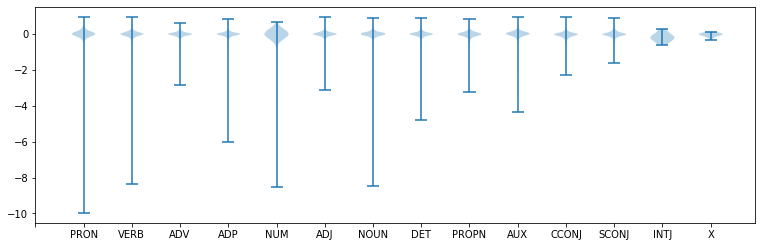

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,3))
ax = fig.add_axes([0,0,1,1])
bp = ax.violinplot(pos_scores)
plt.xticks(np.arange(len(pos_names)+1), [""]+pos_names)
plt.show()

In [15]:
pos = []
neg = []
for scores in word_cxmis_mean:
    for s in scores:
        if s >= 0: 
            pos.append(s.item())
        else:
            neg.append(s.item())

In [16]:
len(pos), len(neg)

(10661, 10686)

In [17]:
sum(pos)/len(pos), sum(neg)/len(neg)

(0.10044231058395926, -0.16652800128139034)

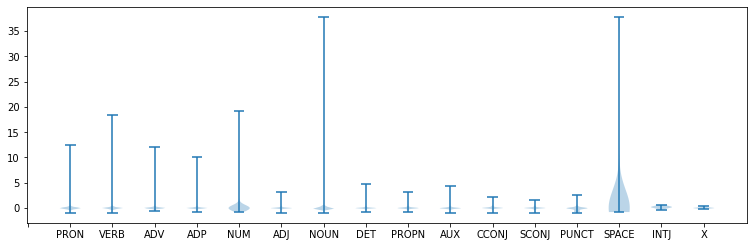

In [149]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,3))
ax = fig.add_axes([0,0,1,1])
bp = ax.violinplot(pos_scores)
plt.xticks(np.arange(len(pos_names)+1), [""]+pos_names)
plt.show()

In [178]:
with open('coword-enfr-word-cxmi-2.txt', 'w') as file:
    for k in range(len(word_cxmis_mean)):
        if k > 7:
            file.write(f'Prev-src: {documents[ids[k-1][0]][ids[k-1][1]][0]}\n')
            file.write(f'Prev-tgt: {documents[ids[k-1][0]][ids[k-1][1]][1]}\n')
        file.write(f'Cur-src: {documents[ids[k][0]][ids[k][1]][0]}\n')
        file.write(f'Cur-tgt: {documents[ids[k][0]][ids[k][1]][1]}\n')
        file.write("CXMI: ")
        for s in word_cxmis_mean[k]:
            file.write(str(round(s.item(), 3)) + ' ')
        file.write('\n')
        if k > 7:
            file.write("Contextual-NLL: ")
            for s in context_ll_mean[k]:
                file.write(str(round(s.item(), 3)) + ' ')
            file.write('\n')
        file.write("Baseline-NLL: ")
        for s in base_ll_mean[k]:
            file.write(str(round(s.item(), 3)) + ' ')
        file.write('\n\n')

In [93]:
min(base_ll_mean)

[0.0032822804,
 0.051517323,
 0.4049058,
 0.64371914,
 0.1054834,
 0.28091332,
 0.09257723,
 0.1465827,
 0.9864934,
 3.5465403,
 0.21285261,
 0.3343617,
 0.26986873,
 0.14813341,
 0.7356855,
 0.37985173,
 4.6503534,
 0.21352619,
 2.082652,
 0.017362388,
 0.10074964,
 0.34067148,
 0.68599176,
 0.053069193,
 0.10363387,
 0.06243922,
 1.1119472,
 0.7840416,
 6.8394656,
 2.8218915]

In [85]:
word_cxmis_mean[k]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [89]:
context_ll_mean == base_ll_mean

False